In [1]:
!pip install pandas-datareader


In [1]:
#Importações básicas

import pandas as pd
import numpy as np
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Carregando a base de dados
df = web.DataReader('FB', data_source='yahoo', start = '2012-01-01', end = '2021-07-23' )
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
2012-05-25,32.950001,31.110001,32.900002,31.910000,37149800,31.910000
2012-05-29,31.690001,28.650000,31.480000,28.840000,78063400,28.840000
2012-05-30,29.549999,27.860001,28.700001,28.190001,57267900,28.190001
2012-05-31,29.670000,26.830000,28.549999,29.600000,111639200,29.600000


In [3]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-07-19,339.790009,334.540009,337.570007,336.950012,14372300,336.950012
2021-07-20,343.450012,334.500000,338.799988,341.660004,11024300,341.660004
2021-07-21,346.519989,341.250000,341.500000,346.230011,9279700,346.230011
2021-07-22,351.540009,345.209991,346.679993,351.190002,12385400,351.190002
2021-07-23,375.329987,357.190002,360.910004,369.790009,33694300,369.790009


In [4]:
df.shape

(2310, 6)

In [5]:
#tratando dos dados
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [6]:
df.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

In [7]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

Text(0, 0.5, 'Close Price (USD)')

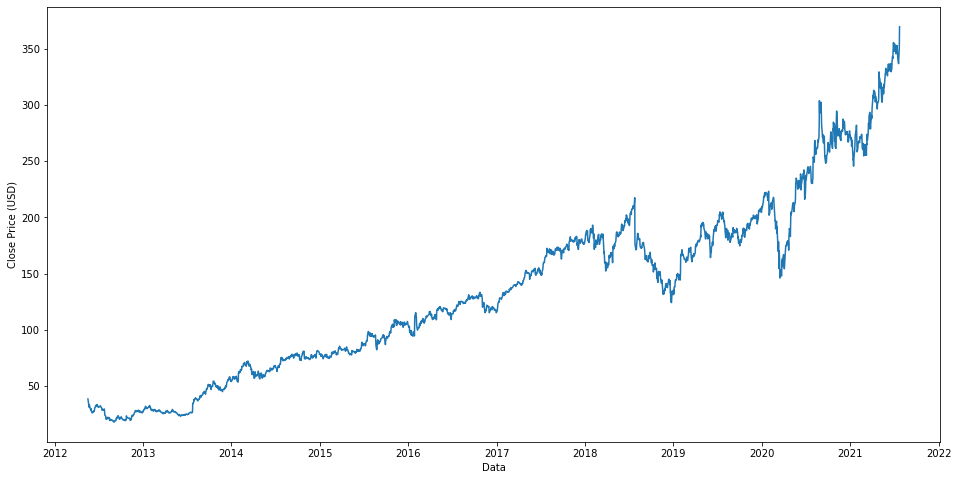

In [8]:
#Plotando os dados
plt.figure(figsize =(16,8))
plt.plot(df['Close'])
plt.xlabel('Data')
plt.ylabel('Close Price (USD)')

In [9]:
#Criando um df somente com a coluna 'Close'
df_close = df.filter(['Close'])

In [11]:
df_close.head()

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999


In [10]:
# Média Móvel de 60 dias

m_mov_60 = df.Close.rolling(60).mean()
m_mov_60

Date
2012-05-18           NaN
2012-05-21           NaN
2012-05-22           NaN
2012-05-23           NaN
2012-05-24           NaN
                 ...    
2021-07-19    330.023333
2021-07-20    330.698833
2021-07-21    331.418667
2021-07-22    332.212333
2021-07-23    333.257167
Name: Close, Length: 2310, dtype: float64

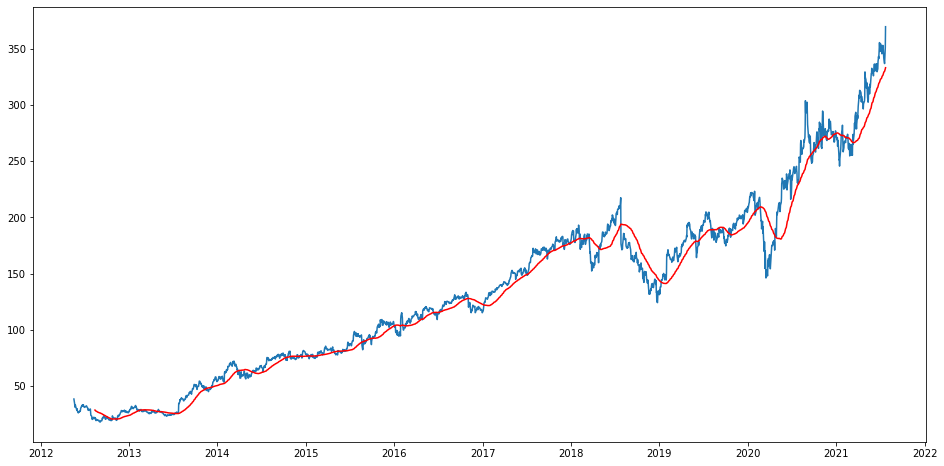

In [8]:
# Gráfico com a média móvel
plt.figure(figsize=(16,8))
plt.plot(df.Close)
plt.plot(m_mov_60, 'r')

In [12]:
#Convertendo para um array
dataset = df_close.values

In [13]:
type(dataset)

numpy.ndarray

In [14]:
#Tamanho do conjunto de treino
df_train_len = math.ceil(len(dataset)*0.8)

df_train_len

1848

In [15]:
#Escalonando os dados

scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df_close)

scaled_df


array([[0.05822871],
       [0.04629892],
       [0.03769244],
       ...,
       [0.9330796 ],
       [0.94716808],
       [1.        ]])

In [16]:
# Criando o df de treino
train_data = scaled_df[0:df_train_len:,]

In [17]:
train_data.shape


(1848, 1)

In [18]:
#dividindo entre x_train e Y_train

x_train = []
y_train = []

for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60:i,0]) # vai do 0 a posição 59
    y_train.append(train_data[i,0])  # valor da posição 60 (valor a ser previsto)
    
x_train, y_train = np.array(x_train), np.array(y_train)
    

In [19]:
# Passando para 3d (LSTM model)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1788, 60, 1)

In [20]:
# Construindo o modelo LSTM

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [21]:
model = Sequential()

model.add(LSTM(units = 64,activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units =32,activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))


model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [22]:
#compilando o modelo
model.compile(optimizer='adam', loss= 'mean_squared_error', metrics = ['accuracy'])

In [23]:
#Treinando o modelo
modelo = model.fit(x_train, y_train, batch_size=32, epochs = 180, validation_split=0.1, verbose = 1)

Epoch 1/180
51/51 [==============================] - 1s 29ms/step - loss: 0.0154 - accuracy: 6.2150e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 2/180
51/51 [==============================] - 1s 23ms/step - loss: 0.0022 - accuracy: 6.2150e-04 - val_loss: 9.6077e-04 - val_accuracy: 0.0000e+00uracy: 6.2500e-
Epoch 3/180
51/51 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 6.2150e-04 - val_loss: 8.0777e-04 - val_accuracy: 0.0000e+00
Epoch 4/180
51/51 [==============================] - 1s 23ms/step - loss: 0.0015 - accuracy: 6.2150e-04 - val_loss: 5.5427e-04 - val_accuracy: 0.0000e+00
Epoch 5/180
51/51 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 6.2150e-04 - val_loss: 6.3731e-04 - val_accuracy: 0.0000e+00
Epoch 6/180
51/51 [==============================] - 1s 23ms/step - loss: 0.0014 - accuracy: 6.2150e-04 - val_loss: 4.4143e-04 - val_accuracy: 0.0000e+00
Epoch 7/180
51/51 [==============================] - 1s 23ms/step

Epoch 53/180
51/51 [==============================] - 1s 26ms/step - loss: 6.0696e-04 - accuracy: 6.2150e-04 - val_loss: 8.2926e-04 - val_accuracy: 0.0000e+00
Epoch 54/180
51/51 [==============================] - 1s 26ms/step - loss: 6.2045e-04 - accuracy: 6.2150e-04 - val_loss: 4.4039e-04 - val_accuracy: 0.0000e+00
Epoch 55/180
51/51 [==============================] - 1s 26ms/step - loss: 5.4809e-04 - accuracy: 6.2150e-04 - val_loss: 3.5151e-04 - val_accuracy: 0.0000e+00
Epoch 56/180
51/51 [==============================] - 1s 26ms/step - loss: 6.0243e-04 - accuracy: 6.2150e-04 - val_loss: 2.7404e-04 - val_accuracy: 0.0000e+00
Epoch 57/180
51/51 [==============================] - 1s 26ms/step - loss: 5.4382e-04 - accuracy: 6.2150e-04 - val_loss: 6.0523e-04 - val_accuracy: 0.0000e+00
Epoch 58/180
51/51 [==============================] - 1s 26ms/step - loss: 5.7580e-04 - accuracy: 6.2150e-04 - val_loss: 3.5872e-04 - val_accuracy: 0.0000e+00
Epoch 59/180
51/51 [==========================

51/51 [==============================] - 1s 26ms/step - loss: 5.5337e-04 - accuracy: 6.2150e-04 - val_loss: 2.4744e-04 - val_accuracy: 0.0000e+00
Epoch 105/180
51/51 [==============================] - 1s 26ms/step - loss: 5.6161e-04 - accuracy: 6.2150e-04 - val_loss: 2.5754e-04 - val_accuracy: 0.0000e+00
Epoch 106/180
51/51 [==============================] - 1s 26ms/step - loss: 5.6748e-04 - accuracy: 6.2150e-04 - val_loss: 6.4029e-04 - val_accuracy: 0.0000e+00
Epoch 107/180
51/51 [==============================] - 1s 26ms/step - loss: 5.7760e-04 - accuracy: 6.2150e-04 - val_loss: 2.0448e-04 - val_accuracy: 0.0000e+00
Epoch 108/180
51/51 [==============================] - 1s 26ms/step - loss: 5.4372e-04 - accuracy: 6.2150e-04 - val_loss: 3.5533e-04 - val_accuracy: 0.0000e+00
Epoch 109/180
51/51 [==============================] - 1s 26ms/step - loss: 5.3832e-04 - accuracy: 6.2150e-04 - val_loss: 1.8457e-04 - val_accuracy: 0.0000e+00
Epoch 110/180
51/51 [==============================] -

51/51 [==============================] - 1s 26ms/step - loss: 5.1267e-04 - accuracy: 6.2150e-04 - val_loss: 1.5573e-04 - val_accuracy: 0.0000e+00
Epoch 156/180
51/51 [==============================] - 1s 26ms/step - loss: 5.4342e-04 - accuracy: 6.2150e-04 - val_loss: 3.0996e-04 - val_accuracy: 0.0000e+00
Epoch 157/180
51/51 [==============================] - 1s 27ms/step - loss: 4.9118e-04 - accuracy: 6.2150e-04 - val_loss: 1.7357e-04 - val_accuracy: 0.0000e+00
Epoch 158/180
51/51 [==============================] - 1s 26ms/step - loss: 4.9180e-04 - accuracy: 6.2150e-04 - val_loss: 2.2570e-04 - val_accuracy: 0.0000e+00
Epoch 159/180
51/51 [==============================] - 1s 26ms/step - loss: 5.0650e-04 - accuracy: 6.2150e-04 - val_loss: 1.5884e-04 - val_accuracy: 0.0000e+00
Epoch 160/180
51/51 [==============================] - 1s 26ms/step - loss: 5.1375e-04 - accuracy: 6.2150e-04 - val_loss: 3.2612e-04 - val_accuracy: 0.0000e+00
Epoch 161/180
51/51 [==============================] -

In [24]:
model.save('awari_modelo.h5')

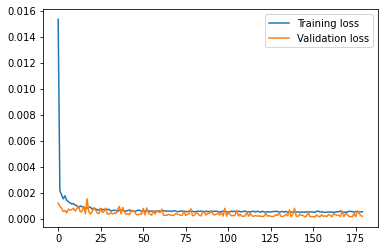

In [25]:
# Curvas training loss e valid loss

plt.plot(modelo.history['loss'], label='Training loss')
plt.plot(modelo.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
#Criando o dataset de teste
test_data = scaled_df[df_train_len - 60:, :]

In [27]:
test_data.shape



(522, 1)

In [28]:
#Criando x_test e y_test
x_test = []
y_test = dataset[df_train_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])



In [29]:
#Convertendo para um array
x_test = np.array(x_test)

In [30]:
#Reshape para 3d
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
# Obter os predicted values

predictions = model.predict(x_test)

predictions = scaler.inverse_transform(predictions)

In [32]:
predictions.shape

(462, 1)

In [33]:
# Métrica: RSME
rmse = math.sqrt(mean_squared_error(predictions, y_test))

print('rmse: %.2f RMSE' % (rmse))

rmse: 20.45 RMSE


<ipython-input-34-9d53e614c7a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


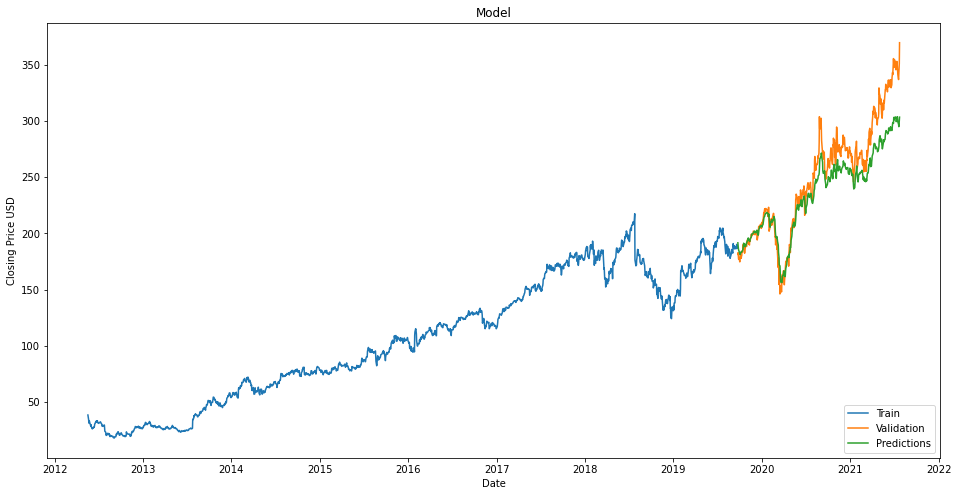

In [34]:
# Plotando os dados

train = df_close[:df_train_len]
valid = df_close[df_train_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Closing Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'lower right')

In [35]:
type(df_close)


pandas.core.frame.DataFrame

In [36]:
# Mostrando os valores reais e os previstos
valid

,Close,Predictions
Date,,
2019-09-24,181.279999,191.594315
2019-09-25,182.800003,188.630005
2019-09-26,180.110001,186.868698
2019-09-27,177.100006,185.287369
2019-09-30,178.080002,183.511856
...,...,...
2021-07-19,336.950012,297.035461
2021-07-20,341.660004,294.986176
2021-07-21,346.230011,296.887177
